In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
data = pd.read_csv("gz2_hart16.csv")

In [3]:
# Mapping of every object id to image
mapping = pd.read_csv("gz2_filename_mapping.csv")
mapping

,objid,sample,asset_id
0,587722981736120347,original,1
1,587722981736579107,original,2
2,587722981741363294,original,3
3,587722981741363323,original,4
4,587722981741559888,original,5
...,...,...,...
355985,8647475122541625731,stripe82_coadd_2,355986
355986,8647475122541625762,stripe82_coadd_2,355987
355987,8647475122541625774,stripe82_coadd_2,355988
355988,8647475122761762019,stripe82_coadd_2,355989


In [4]:
# Sample the data size to reduce training time
data = data.sample(frac = 0.35)
data.reset_index(inplace = True)

In [5]:
data

,index,dr7objid,ra,dec,rastring,decstring,sample,gz2_class,total_classifications,total_votes,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,204928,587736812059558179,232.651978,9.378864,15:30:36.47,+09:22:43.9,original,Sb,43,144,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
1,205061,587742014880809055,151.342285,19.816113,10:05:22.15,+19:48:58.0,original,SBc?m,54,186,...,0.000,0.000,0.000000,0,1,1.0,0.500,0.586,0.469122,0
2,151355,587741726584471725,199.551041,24.688847,13:18:12.25,+24:41:19.8,original,SBc2m,38,296,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
3,192215,587739406754513360,117.636330,14.745845,07:50:32.72,+14:44:45.0,original,Er,43,137,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
4,28159,588298661969657981,206.163620,44.416023,13:44:39.27,+44:24:57.7,original,Sb?t,37,199,...,0.062,0.062,0.172197,0,9,9.0,0.562,0.562,0.533747,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83888,168467,587735349091959139,138.029572,10.949784,09:12:07.10,+10:56:59.2,original,Sb,53,175,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
83889,64721,588017991773323489,227.056213,7.780035,15:08:13.49,+07:46:48.1,original,Ei,48,152,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
83890,15320,587729747913408742,234.152191,1.801342,15:36:36.53,+01:48:04.8,original,Sc?t,56,306,...,0.040,0.040,0.083998,0,14,14.0,0.560,0.560,0.532222,0
83891,8690,587739505005887605,182.488953,32.006844,12:09:57.35,+32:00:24.6,original,Sb2t,38,278,...,0.000,0.000,0.000000,0,9,9.0,0.290,0.299,0.270380,0


In [6]:
# Split the galaxies into Spiral and Elliptical only
for i in range(len(data["gz2_class"])):
    if "S" in data["gz2_class"][i]:
        data["gz2_class"][i] = "S"
    if "E" in data["gz2_class"][i]:
        data["gz2_class"][i] = "E"
        
i = data[data["gz2_class"] == 'A'].index
data = data.drop(i)

# Make the target columns
data["Elliptical"] = (data["gz2_class"] == 'E').astype(int)
data["Spiral"] = (data["gz2_class"] == 'S').astype(int)

<ipython-input-6-e29fbacaf870>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gz2_class"][i] = "S"
<ipython-input-6-e29fbacaf870>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gz2_class"][i] = "E"


In [7]:
# Segment the data 
data_seg = data[["dr7objid", "Elliptical", "Spiral"]].reset_index()
data_seg.drop("index", axis=1, inplace = True)

In [8]:
data_seg

,dr7objid,Elliptical,Spiral
0,587736812059558179,0,1
1,587742014880809055,0,1
2,587741726584471725,0,1
3,587739406754513360,1,0
4,588298661969657981,0,1
...,...,...,...
83669,587735349091959139,0,1
83670,588017991773323489,1,0
83671,587729747913408742,0,1
83672,587739505005887605,0,1


Text(0, 0.5, 'number of occurrences')

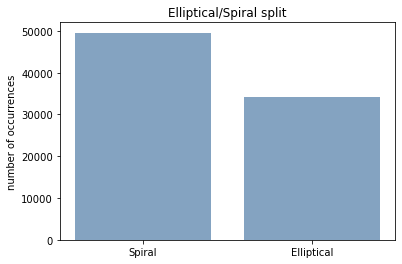

In [23]:
# Plot Elliptical/Spiral split
plt.bar(["Spiral","Elliptical"], [data_seg["Spiral"].sum(), data_seg["Elliptical"].sum()], color = (0.2, 0.4, 0.6, 0.6))
plt.title("Elliptical/Spiral split")
plt.ylabel("number of occurrences")

In [24]:
# 59% are spiral, 41% are Elliptical
data_seg["Spiral"].sum() / (data_seg["Spiral"].sum() + data_seg["Elliptical"].sum())

0.5923703898463083